In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
#from langchain_anthropic import ChatAnthropic
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY", "ANTHROPIC_API_KEY"]

for var in vars:
    set_env_vars(var)

llm_openai = ChatOpenAI(model="gpt-4o", temperature=0)
llm_mini = ChatOpenAI(model="gpt-4o-mini", temperature=0)
#llm_anthropic = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)
llm_openai_o1 = ChatOpenAI(model="o1-preview", temperature=1)
llm = llm_openai

import nest_asyncio
nest_asyncio.apply()

# State Definition

In [4]:
from typing import TypedDict, List, Annotated
from playwright.async_api import Page
from langchain_core.messages import BaseMessage
from operator import add

class Bbox(TypedDict):
    x: int
    y: int
    text: str
    type: str
    ariaLabel: str

class Action(TypedDict):
    action: str
    args: str | Bbox

class MasterPlanState(TypedDict):
    plan: List[str]



class AgentState(TypedDict):
    input: str
    page: Page
    image: str
    master_plan: MasterPlanState
    bboxes: List[Bbox]
    actions_taken: Annotated[List[str], add]
    action: Action | str
    last_action: str
    notes: Annotated[List[str], add]
    answer: str


# ScreenShot and Annotation Helper Functions

In [5]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io
from playwright.async_api import Page


with open("mark_page.js") as f:
    mark_page_script = f.read()

async def is_image_blank(image_bytes: bytes) -> bool:
    """Return True if the screenshot is fully blank (e.g. all white), else False."""
    if not image_bytes:
        return True
    img = PILImage.open(io.BytesIO(image_bytes)).convert("L")
    # If getbbox() returns None, the image is entirely one color
    return img.getbbox() is None

async def capture_screenshot(page: Page, max_retries=3, wait_seconds=2) -> bytes:
    """Take a screenshot, retry if blank (completely white)."""
    screenshot_bytes = b""
    for attempt in range(max_retries):
        # Wait for the page to be fully loaded
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot
        screenshot_bytes = await page.screenshot(path="screenshot.jpg", type="jpeg", quality=60, scale="device")
        
        # Check if it's blank
        if not await is_image_blank(screenshot_bytes):
            return screenshot_bytes
        
        # If blank, wait a bit and retry
        print(f"[capture_screenshot] Screenshot is blank (attempt {attempt+1}/{max_retries}). Retrying...")
        await asyncio.sleep(wait_seconds)
    
    # If we get here, all attempts yielded a blank screenshot
    print("[capture_screenshot] All screenshot attempts were blank.")
    return screenshot_bytes  # Return whatever we got last


async def mark_page(page):

    """
    1. Wait for the page to be loaded using 'networkidle'.
    2. Attempt to run a 'mark_page_script' that presumably marks and returns bounding boxes.
    3. Retry up to 10 times if it fails.
    4. Capture a screenshot with retry logic (up to 3 tries) if the page is blank.
    5. Process screenshot (grayscale, resize, quantize, compress).
    6. Remove the markings before returning.
    """

    bboxes = []

    for attempt in range (3):
        
        try: 
            await page.wait_for_load_state("networkidle")
            await page.wait_for_load_state("domcontentloaded")
            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            
            break
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/3 failed to mark page: {e}")
            await asyncio.sleep(3)
    # Get screenshot as bytes
    await page.wait_for_load_state("networkidle")
    screenshot_bytes = await capture_screenshot(page, max_retries=3)
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        # Convert to grayscale
        img = img.convert('L')
        # Resize
        max_size = (600, 600)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        # Quantize and convert back to grayscale
        img = img.quantize(colors=256).convert('RGB')
        
        # Compress
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=50,      # Low quality -> smaller size
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        # If screenshot is empty or never taken, handle gracefully
        print("[mark_page] Using empty screenshot due to failure or blank screenshot.")
        compressed_bytes = b""

    await page.wait_for_load_state("networkidle")
    try:
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"[mark_page] Could not unmark page: {e}")

    # Build final result
    return {
        "image": base64.b64encode(compressed_bytes).decode("utf-8"),
        "bboxes": bboxes
    }

# Browser setup

In [6]:
async def setup_browser_2(go_to_page: str):
    playwright = await async_playwright().start()
    
    # Add browser arguments to appear more human-like
    browser_args = [
        '--disable-dev-shm-usage',
        '--disable-blink-features=AutomationControlled',  # Hide automation
        '--no-sandbox',
        '--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',  # Use a common user agent
    ]
    
    # Add browser context options
    context_options = {
        "viewport": {"width": 1280, "height": 720},  # Standard desktop resolution
        "user_agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        "permissions": ['geolocation'],
        "geolocation": {"latitude": 37.7749, "longitude": -122.4194},  # Set a fixed location
        "locale": 'en-US',
        "timezone_id": 'America/Los_Angeles',
    }
    
    browser = await playwright.chromium.launch(
        headless=False,
        args=browser_args
    )
    
    # Create context with the specified options
    context = await browser.new_context(**context_options)
    
    # Enable JavaScript and cookies
    await context.add_init_script("""
        Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
        });
    """)
    
    page = await context.new_page()
    
    try:
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    
    return playwright, browser, page

# Nodes 
- Master Plan Node
- Page Annotation Node
- LLM Call Node
- Parse Action Node
- Answer Node


## Master Plan Node

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

async def master_plan_node(state: AgentState):

    screen_shot = await mark_page(state["page"])
    

    system_message = """
    You are an expert a preparing a step by step plan to complete a task.
    You will be given a task provided by the user. The task might also be a question.
    You will need to prepare a plan to complete the task. In case its a question, you will need to prepare a plan to answer the question.

    You will be also provided the screenshot of the current web page.
    - If the current page is google home page or any other search engine, create a plan that basically searches the keyword and continues to the next step.
    - If the current page is not a some other web page, create a plan to scroll through the page and relevant collect information. 

    For eg if the task is "What is the lastest news on Apple's stock price?", you will need to prepare a plan to answer the question.
    You will need to prepare a plan to complete the task.

    For example, if the task is "What is the latest news on Apple's stock price?", your plan might look like this:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    Your plan should be clear, sequential, and focused on achieving the user's goal efficiently. 

    --Notes--
    The browser is already open. First page will always be google, so plan accordingly with a search term.
    For any question, you will need to go to google and search for the question.
    """ 

    human_prompt = """ This is the task that needs to be performed/question that needs to be answered: {input} \n This is the screenshot of the current web page: {screenshot}"""

    input = state["input"]

    human_message = human_prompt.format(input=input, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]
    structured_llm = llm.with_structured_output(MasterPlanState)

    response = structured_llm.invoke(messages)
    

    return {"master_plan": [response]}



## Page Annotation Node

In [8]:
async def annotate_page(state: AgentState):
    page = state["page"]
    result = await mark_page(page)
    return {"image": result["image"], "bboxes": result["bboxes"]}

## LLM Call Node

In [9]:
from langchain_core.prompts import ChatPromptTemplate

async def llm_call_node(state: AgentState):   

    template =  """Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration,
    you will receive an Observation that includes a screenshot of a webpage and some texts. 
    Carefully analyze the bounding box information and the web page contents to identify the Numerical Label corresponding 
    to the Web Element that requires interaction, then follow
    the guidelines and choose one of the following actions:

    1. Click a Web Element.
    2. Delete existing content in a textbox and then type content.
    3. Scroll up or down.
    4. Wait 
    5. Go back
    7. Return to google to start over.
    8. Respond with the final answer

    Correspondingly, Action should STRICTLY follow the format:

    - Click [Numerical_Label] 
    - Type [Numerical_Label]; [Content] 
    - Scroll [Numerical_Label or WINDOW]; [up or down] 
    - Wait 
    - GoBack
    - Google
    - Respond 

    Key Guidelines You MUST follow:

    * Action guidelines *
    1) Execute only one action per iteration.
    2) Always click close on the popups.
    3) When clicking or typing, ensure to select the correct bounding box.
    4) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
    5) Try to scroll down if a pdf or a document is opeened to read the entire document., if you dont find the information you need, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.

    Your reply should strictly follow the format:
    Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
    Action: {{One Action format you choose}} (Make sure to enclose the bbox id in [] , for eg  Click [1], Type [5], Scroll [10] or Scroll [WINDOW])
    
    Then the User will provide:
    Observation: {{A labeled bounding boxes and contents given by User}}"
    Actions Taken: {{A list of actions taken so far}} (Could be empty, if it is the first iteration)
    Master Plan: {{A set of steps that you can use as a reference to complete the task}}

    Observation including a screenshot of a webpage with bounding boxes and the text related to it: {{result}}"""


    prompt = ChatPromptTemplate(
        messages=[
            ("system", template),
            ("human", "Input: {input}"),
            ("human", "Actions Taken So far: {actions_taken}"),
            ("human", "Observation: Screenshot: {image}"),
            ("human", "Observation: Bounding Boxes: {bboxes}"),
            
        ],
        input_variables=["image", "bboxes", "input"],
        partial_variables={"actions_taken": []},
        optional_variables=["actions_taken"]
    )
    
    

    actions_taken = state.get("actions_taken", [])
    image = state["image"]
    bboxes = state["bboxes"]
    input = state["input"]
    master_plan = state["master_plan"]
    
    prompt_value = prompt.invoke({"actions_taken": actions_taken, "image": image, "bboxes": bboxes, "input": input, "master_plan": master_plan})
    
    response = llm.invoke(prompt_value)

    action = response.content
    
    return {"action": action}


## Parse Action Node

In [10]:
async def parse_action_node(state: AgentState):
    action_prefix = "Action: "
    text = state["action"]
    if not text.strip().split("Action:")[-1]:
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("Action: ")[-1]
    thought_block = text.strip().split("Action: ")[0].split("Thought: ")[-1]
    split_output = action_block.split("; ", 1)
    if len(split_output) == 1:
        action, args = split_output[0], None
    else:
        action, args = split_output

    return {"action": Action(action=action, args=args), "notes": [thought_block]}


In [11]:
tools = {
    "Click": "click",
    "Type": "type",
    "Scroll": "scroll",
    "Wait": "wait",
    "GoBack": "go_back",
    "Google": "go_to_search_engine"
}



def tool_router(state: AgentState):
    action = state["action"]["action"]
    action_type = action.split(" ")[0]
    if action_type == "retry":
        return "annotate_page"
    if action_type == "Respond":
        return "answer_node"
    return tools[action_type]


## Answer Node

In [12]:
async def answer_node(state: AgentState):
    system_message_answer = """ You are an assistant who is expert at answering the user input based on the notes.
    You will be given:
    Notes: {notes}
    User Input: {input}

    Breakdown the Answer in to two sections:
    1. Steps: A list of steps were taken to surf the web and provide answer to the user input.
    2. Final Answer: Should only contain the final answer that directly provides answer to the user input.

    Provide the answer in proper markdown format. Use proper markdown formatting for the steps and final answer.
    """

    prompt_answer = ChatPromptTemplate(
        messages=[
            ("system", system_message_answer),
        ],
        input_variables=["notes", "input"],
    )   

    notes = state["notes"]
    input = state["input"]

    prompt_value_answer = prompt_answer.invoke({"notes": notes, "input": input})
    response_answer = llm_mini.invoke(prompt_value_answer)
    answer = response_answer.content
    
    return {"answer": answer}


# Tools
1. Click (at labelled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)

### Click

In [13]:
async def click(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split(" ")[1].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await asyncio.sleep(2)
    await page.mouse.click(bbox["x"], bbox["y"])
    await asyncio.sleep(4)
    return {"last_action": f"Click : clicked on {bbox_id}", "actions_taken": [f"Click : clicked on {bbox_id}"]}


### Scroll

In [14]:
async def scroll_2(state: AgentState):
    page = state["page"]
    action = state["action"]
    scroll_type = action["action"].split(" ")[1].split("[")[1].split("]")[0]
    direction = action["args"]
    
    async def is_pdf_page():
        current_url = page.url
        return (
            current_url.lower().endswith('.pdf') or
            'pdf' in current_url.lower() or
            '/pdf/' in current_url.lower()
        )

    async def try_scroll_methods(is_down: bool):
        keys = ["PageDown", "Space", "ArrowDown", "j"] if is_down else ["PageUp", "ArrowUp", "k"]
        # Reduced to just one key press for more controlled scrolling
        for key in keys:
            try:
                await page.keyboard.press(key)
                await page.wait_for_timeout(100)
                break  # Exit after first successful key press
            except Exception as e:
                print(f"Failed with key {key}: {str(e)}")
                continue

    if scroll_type == "WINDOW":
        is_pdf = await is_pdf_page()
      
        
        if is_pdf:
            try:
                # Wait for PDF to load
                await page.wait_for_load_state('networkidle')
                await page.wait_for_timeout(1000)

                # Try to click on the PDF to ensure focus
                try:
                    await page.mouse.click(300, 300)  # Click somewhere in the middle of the page
                except Exception:
                    pass

                # Single scroll attempt
                await try_scroll_methods(direction.lower() == "down")
                await page.wait_for_timeout(500)
                
                return {
                    "last_action": f"Scroll : scrolled {direction} on PDF document",
                    "actions_taken": [f"Scroll : scrolled {direction} on PDF document"]
                }
                
            except Exception as e:
                print(f"PDF scrolling error: {str(e)}")
                return {
                    "action": "retry",
                    "args": f"Error scrolling PDF: {str(e)}",
                    "actions_taken": [f"Error scrolling PDF: {str(e)}"]
                }
        else:
            # Regular webpage scrolling with exactly 500px
            scroll_amount = 500  # Changed from 800 to 500
            scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
            try:
                await page.evaluate(f"""
                    window.scrollBy({{
                        top: {scroll_direction},
                        left: 0,
                        behavior: 'smooth'
                    }});
                """)
            except Exception:
                await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        
        await page.wait_for_timeout(500)
        
        return {
            "last_action": f"Scroll : scrolled {direction}",
            "actions_taken": [f"Scroll : scrolled {direction}"]
        }
    
    else:
        # Element-specific scrolling
        try:
            bbox_id = int(action["action"].split("[")[1].split("]")[0])
            if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
                return {
                    "action": "retry",
                    "args": f"Could not find bbox with id {bbox_id}",
                    "actions_taken": [f"Could not find bbox with id {bbox_id}"]
                }
                
            bbox = state["bboxes"][bbox_id]
            scroll_amount = 200
            scroll_direction = -scroll_amount if direction.lower() == "up" else scroll_amount
            
            await page.mouse.move(bbox["x"], bbox["y"])
            await page.mouse.wheel(0, scroll_direction)
            
            return {
                "last_action": f"Scroll : scrolled {direction} at element {bbox_id}",
                "actions_taken": [f"Scroll : scrolled {direction} at element {bbox_id}"]
            }
            
        except Exception as e:
            return {
                "action": "retry",
                "args": f"Error scrolling element: {str(e)}",
                "actions_taken": [f"Error scrolling element: {str(e)}"]
            }

### Type

In [15]:
import platform

async def type(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await asyncio.sleep(2)
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await asyncio.sleep(1)
    await page.keyboard.press("Backspace")
    await asyncio.sleep(1)
    await page.keyboard.type(action["args"])
    await asyncio.sleep(3)
    await page.keyboard.press("Enter")
    await asyncio.sleep(3)
    return {"last_action": f"Type : typed {action['args']} into {bbox_id}", "actions_taken": [f"Type : typed {action['args']} into {bbox_id}"]}


### Wait

In [16]:
async def wait(state: AgentState):
    await asyncio.sleep(3)
    return {"last_action": "Wait : waited for 3 seconds", "actions_taken": ["Wait : waited for 3 seconds"]}


### Go Back

In [17]:
async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return {"last_action": f"Go Back : Navigated back to page {page.url}", "actions_taken": [f"Go Back : Navigated back to page {page.url}"]}


### Go to Search Engine

In [18]:
async def go_to_search_engine(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com")
    return {"last_action": "Go to Search Engine : Navigated to Google", "actions_taken": ["Go to Search Engine : Navigated to Google"]}


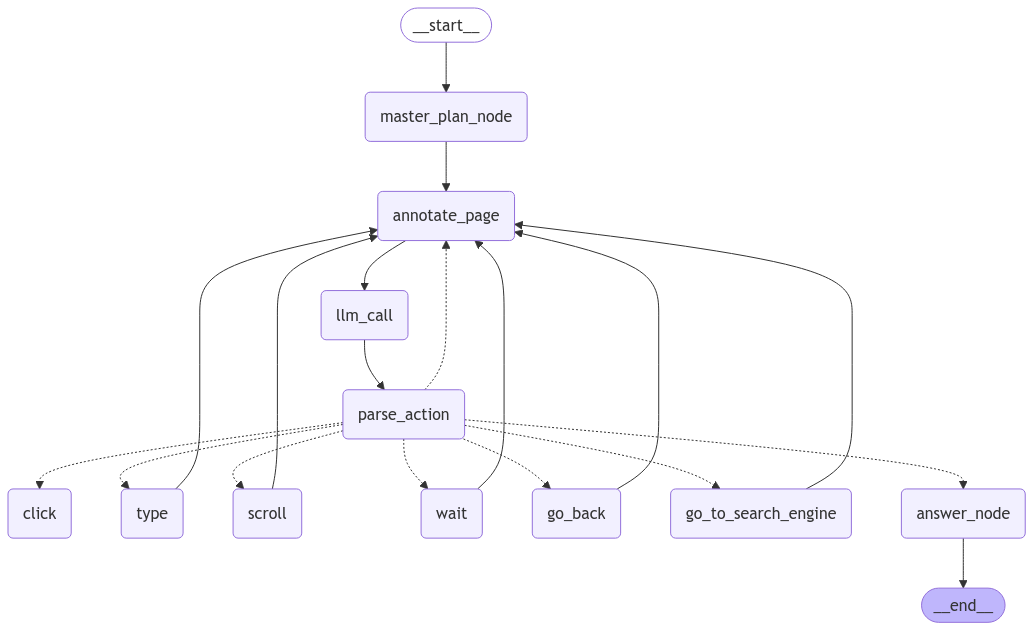

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("annotate_page", annotate_page)
builder.add_node("llm_call", llm_call_node)
builder.add_node("parse_action", parse_action_node)
builder.add_node("master_plan_node", master_plan_node)
builder.add_node("click", click)
builder.add_node("type", type)
builder.add_node("scroll", scroll_2)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_search_engine", go_to_search_engine)
builder.add_node("answer_node", answer_node)

builder.add_edge(START, "master_plan_node")
builder.add_edge("master_plan_node", "annotate_page")
builder.add_edge("annotate_page", "llm_call")
builder.add_edge("llm_call", "parse_action")
builder.add_conditional_edges("parse_action", tool_router, ["annotate_page",  "click", "type", "scroll", "wait", "go_back", "go_to_search_engine", "answer_node"])
builder.add_edge("click", "annotate_page")
builder.add_edge("type", "annotate_page")
builder.add_edge("scroll", "annotate_page")
builder.add_edge("wait", "annotate_page")
builder.add_edge("go_back", "annotate_page")
builder.add_edge("go_to_search_engine", "annotate_page")
builder.add_edge("answer_node", END)

main_agent_graph = builder.compile()

display(Image(main_agent_graph.get_graph(xray=1).draw_mermaid_png()))

# Testing with Inputs

### Setup Browser

In [20]:
result = await setup_browser_2("https://www.google.com/")
playwright, browser, page = result

### Input 1

In [64]:
type(page)

<coroutine object type at 0x10bb8e540>

In [ ]:
from IPython.display import Markdown
input = "How long is the drive from Tucson to LA?"
state = AgentState(page=page, input=input)

event_stream = main_agent_graph.astream(
            state,
            {"recursion_limit": 400}
)

answer = ""
async for event in event_stream:
    if "parse_action" in event:
        thought = event["parse_action"]["notes"][-1]
        print(thought)
        action = event["parse_action"]["action"]
        print(action)
    if "answer_node" in event:
        answer = event["answer_node"]["answer"]
        print(answer)

Markdown(answer)



### Input 2


In [23]:
from IPython.display import Markdown
input = "Go to google maps and find the time I should leave from my location (1850 N Tyndall Ave, Tucson AZ 85719) to reach Phoenix Airport before 10:00 AM"
state = AgentState(page=page, input=input)

event_stream = main_agent_graph.astream(
            state,
            {"recursion_limit": 400}
)

answer = ""
async for event in event_stream:
    if "parse_action" in event:
        thought = event["parse_action"]["notes"][-1]
        print(thought)
        action = event["parse_action"]["action"]
        print(action)
        print("--------------------------------")
    if "answer_node" in event:
        answer = event["answer_node"]["answer"]
        print(answer)

Markdown(answer)


I need to search for directions from 1850 N Tyndall Ave, Tucson AZ 85719 to Phoenix Airport on Google Maps to find the time to leave. I will start by typing the search query in the Google search bar.


{'action': 'Type [7]', 'args': '"Google Maps"'}
I need to click on the "Google Maps" link to open Google Maps and proceed with finding the travel time.

{'action': 'Click [24]', 'args': None}
I need to input the starting location and destination into Google Maps to find the travel time. The input box with id 0 seems to be the search bar where I can type the addresses.

{'action': 'Type [0]', 'args': '1850 N Tyndall Ave, Tucson AZ 85719 to Phoenix Airport'}
The fastest route from 1850 N Tyndall Ave, Tucson, AZ to Phoenix Sky Harbor International Airport takes 1 hour and 36 minutes. To arrive before 10:00 AM, I should leave by 8:24 AM at the latest. 

{'action': 'Respond', 'args': None}
1. Steps:
   - I started by searching for directions from 1850 N Tyndall Ave, Tucson AZ 85719 to Phoenix

1. Steps:
   - I started by searching for directions from 1850 N Tyndall Ave, Tucson AZ 85719 to Phoenix Airport on Google Maps.
   - I clicked on the "Google Maps" link to open the map service.
   - I input the starting location (1850 N Tyndall Ave, Tucson AZ 85719) and the destination (Phoenix Sky Harbor International Airport) into Google Maps.
   - I found that the fastest route takes 1 hour and 36 minutes.
   - To arrive before 10:00 AM, I calculated that I should leave by 8:24 AM at the latest.

2. Final Answer:
You should leave by 8:24 AM at the latest to reach Phoenix Airport before 10:00 AM.

### Input 3

In [21]:
from IPython.display import Markdown
input = "Go to google flights and find the cheapest flight departing from Tucson to destination Austin and departing on 2/1/2025 and returning on 2/10/2025"
state = AgentState(page=page, input=input)

event_stream = main_agent_graph.astream(
            state,
            {"recursion_limit": 400}
)

answer = ""
async for event in event_stream:
    if "parse_action" in event:
        action = event["parse_action"]["action"]
        action_block = action["action"] + ((":" + action["args"] )if action["args"] else "")
        print(action_block)
        print("--------------------------------")

    if "answer_node" in event:
        answer = event["answer_node"]["answer"]
        print(answer)

Markdown(answer)

Type [8]:Google Flights
--------------------------------
Click [19]
--------------------------------
Type [13]:Tucson
--------------------------------
Type [14]:Austin
--------------------------------
Type [16]:2/1/2025
--------------------------------
Click [77]
--------------------------------
Click [60]
--------------------------------
Click [82]
--------------------------------
Click [22]
--------------------------------
Click [55]
--------------------------------
Click [44]
--------------------------------
Respond The cheapest flight from Tucson to Austin departing on 2/1/2025 and returning on 2/10/2025 is priced at $179.
--------------------------------
# Steps
1. I searched for "Google Flights" to find the cheapest flight from Tucson to Austin.
2. I clicked on the link that took me to Google Flights, specifically the one labeled "Find Cheap Flight Options & Track Prices."
3. I entered the departure city, Tucson, in the "Where from?" input field.
4. I entered the destination city

# Steps
1. I searched for "Google Flights" to find the cheapest flight from Tucson to Austin.
2. I clicked on the link that took me to Google Flights, specifically the one labeled "Find Cheap Flight Options & Track Prices."
3. I entered the departure city, Tucson, in the "Where from?" input field.
4. I entered the destination city, Austin, in the "Where to?" input field.
5. I entered the departure date, which is 2/1/2025.
6. I selected the return date, which is February 10, 2025.
7. I searched for flights to find the cheapest option.
8. I found the cheapest flight from Tucson to Austin priced at $179.

# Final Answer
The cheapest flight from Tucson to Austin, departing on 2/1/2025 and returning on 2/10/2025, is priced at $179.